In [3]:
import sys
sys.path.append('/mnt/disk05/note/workspaces/duxx')
from feature_selector import FeatureSelector
from unity import init_pkg as ini
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split,cross_val_predict
import scorecardpy as sc
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.datasets import make_classification
from functools import reduce
from sklearn.model_selection import StratifiedKFold

% matplotlib inline

In [4]:
# df_lis = [ini.pd.read_csv('data/'+i) for i in ['all_rest1.csv','all_rest2.csv','all_rest3.csv']]
# df_lis[0] = df_lis[0].drop('Unnamed: 0',axis=1)
# df_lis[1] = df_lis[1].rename({'ID_CARD_NO':'cert_no'},axis=1)
# df_lis[0] = df_lis[0].drop('tag',axis=1)
# comb_main = reduce(lambda x,y:x.merge(y,on='cert_no'),df_lis)
# comb_main.to_csv('data/comb_main.csv',index=False)

In [5]:
# comb_main[comb_main['type'] == 1]['tag'].value_counts()

# 1.数据合并

## 1.1 渠道特征

In [6]:
datset = ini.pd.read_csv('data/comb_main.csv')

In [7]:
# datset[datset['type'] == 3]['tag'].value_counts()

In [8]:
datset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64267 entries, 0 to 64266
Data columns (total 18 columns):
cert_no                        64267 non-null object
LN_CNT_UNSQUARE_LEVEL          63349 non-null float64
CC_LIMIT_MAX_LEVEL             63783 non-null float64
CC_ORG_CNT_LEVEL               39503 non-null float64
qd                             64267 non-null object
CC_DELQ_NOW_OVDUE_MAX_LEVEL    64267 non-null int64
CC_DELQ_NOW_STAT_MAX_LEVEL     64267 non-null int64
CC_LN_QRY_TIMES_L1ST_LEVEL     64267 non-null int64
HOUSE_FUND_MONTH_PAYAMT        29543 non-null float64
tag                            64267 non-null float64
CUSTOMER_NO                    64267 non-null object
mobile_no                      64267 non-null int64
cust_name(md5)                 50000 non-null object
mobile_no(md5)                 64267 non-null object
zx_cc_now_total_amt_level      63783 non-null float64
zx_ln_now_total_amt_level      63783 non-null float64
zx_cc_use_rate                 63788 non

In [9]:
# datset = datset.drop(['qd','type'],axis=1)

In [10]:
datset = datset.assign(gender = lambda x:(x.cert_no.str.get(16).astype(int) % 2 == 0).astype(int),\
              resid_prov = lambda x:x.cert_no.str.slice(0,7).astype(int) // 100000 * 10000)

In [11]:
fs = FeatureSelector(datset.drop('tag',axis=1),labels=datset['tag'])
fs.identify_single_unique()

0 features with a single unique value.



## 1.2 外部特征

### 友盟数据

In [30]:
ym = ini.pd.read_excel('data/other/ym/result_1.xlsx')

In [31]:
ym.shape

(20000, 7)

In [32]:
ym_comb = datset.merge(ym,on='mobile_no(md5)')

### 冰鉴数据

In [11]:
hy = ini.pd.read_excel('data/other/bj/haoyue.xlsx')
tc = ini.pd.read_excel('data/other/bj/tancha.xlsx')
xy = ini.pd.read_excel('data/other/bj/xingyuplus.xlsx')

In [12]:
hy = hy.rename({'手机号':'mobile_no(md5)'},axis=1)
tc = tc.rename({'手机号':'mobile_no(md5)'},axis=1)
xy = xy.rename({'手机号':'mobile_no(md5)'},axis=1)
hy = hy.drop(['姓名','回溯时间','身份证号'],axis=1)
tc = tc.drop(['姓名','回溯时间','身份证号'],axis=1)
xy = xy.drop(['姓名','回溯时间','身份证号'],axis=1)

In [13]:
# hy_comb = datset.merge(hy,on='mobile_no(md5)')
# tc_comb = datset.merge(tc,on='mobile_no(md5)')
# xy_comb = datset.merge(xy,on='mobile_no(md5)')

In [14]:
bj_comb = reduce(lambda x,y:x.merge(y,on='mobile_no(md5)'),[datset,hy,tc,xy])

# 2.建模测试

## 2.1 友盟-单渠道数据建模

In [33]:
ym_comb.head()

,cert_no,LN_CNT_UNSQUARE_LEVEL,CC_LIMIT_MAX_LEVEL,CC_ORG_CNT_LEVEL,qd,CC_DELQ_NOW_OVDUE_MAX_LEVEL,CC_DELQ_NOW_STAT_MAX_LEVEL,CC_LN_QRY_TIMES_L1ST_LEVEL,HOUSE_FUND_MONTH_PAYAMT,tag,CUSTOMER_NO,mobile_no,cust_name(md5),mobile_no(md5),zx_cc_now_total_amt_level,zx_ln_now_total_amt_level,zx_cc_use_rate,type,gender,resid_prov,回溯日期1,res_code,score_1,score_2,score_3,score_4
0,321322199402254638,1002.0,1002.0,1002.0,mt,1002,1003,1002,NaN,0.0,1000000168941989,13951593025,89717a1d754f6100c209d6c80567c6b1,d9e576071682f4ea764d675ab70f3cad,1.0,1.0,0.0,1,0,320000,20190928,0,558.0,619.0,561.0,528.0
1,530125199608230451,1002.0,1002.0,1003.0,mt,1002,1003,1002,NaN,0.0,1000000136280965,18214571597,d80573f7a4f9d293175de71434d90676,96af289305ca60e7b8d55df77b943488,1.0,1.0,1.0,1,0,530000,20190906,0,575.0,566.0,478.0,503.0
2,460006199106166856,1002.0,1002.0,1002.0,mt,1002,1002,1002,NaN,1.0,1000000126641150,18289898563,5bd2cfe5f566f7afe890f9d856d558e1,3c9087ee35e091f25fac4198b4ae7294,1.0,1.0,1.0,1,0,460000,20190829,0,591.0,580.0,496.0,505.0
3,622701199108043700,1003.0,1002.0,1003.0,mt,1002,1003,1002,NaN,1.0,1000000125104933,18193380549,82cc7f6079abcdff114013f62f243d5d,fca8c395ab694044a5b410d76eb93cdf,1.0,1.0,1.0,1,1,620000,20190820,0,567.0,551.0,471.0,463.0
4,450121198712104615,1003.0,1002.0,1003.0,mt,1002,1003,1002,NaN,0.0,1000000119979177,18878720729,05f279df03a49f07e2a60202abd2cff3,bafb3f927132726c418d47cb7d19ccf6,1.0,1.0,1.0,1,0,450000,20190828,0,575.0,600.0,530.0,524.0


In [36]:
ymx = ym_comb.loc[:,~ym_comb.columns.str.contains('mobile_no|cert_no|_NO|回溯|res_code|tag|md5|score_1|score_2|score_3|type|qd')]
ymy = ym_comb['tag']

In [38]:
def model_test(x,y,fs_drop_option=True,eval_option=True):
    if fs_drop_option: x,fs_drop_feas = fs_drop(x,y)
#     lgbc = LGBMClassifier(max_depth=5,num_leaves=20,early_stop_round=50,reg_lambda = 0.05,random_state=123)
    lgbc = LGBMClassifier(max_depth=10,num_leaves=15,random_state=123)
    try:
        train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=123,shuffle=y,test_size=0.3)
        lgbc.fit(train_x,train_y)
        cn_en_trans = set(x.columns)
    except:
        cn_en_trans = {i:k for i,k in enumerate(x.columns)}
        x.columns = cn_en_trans.keys()
        train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=123,shuffle=y,test_size=0.3)
        lgbc.fit(train_x,train_y)
    if eval_option:
        fig,axs = ini.plt.subplots(1,2,figsize=(12,4))
        fig.suptitle('Model Result')
        tra_auc = eval_model(lgbc,train_x,train_y,axs[0])
        tst_auc = eval_model(lgbc,test_x,test_y,axs[1],title='Test')
    return {'fs_drop_feas':fs_drop_feas,'model':lgbc,
            'eval_indicator':{'train_auc':tra_auc,'test_auc':tst_auc},
            'fea_name_trans':cn_en_trans}

def single_eval(x,y,comb,mod,fs_drop=None,types=(1,2,3)):
    if fs_drop: x = x.drop(fs_drop,axis=1)
    f,axs = ini.plt.subplots(1,len(types),figsize=(6*len(types),4))
    for i in types:
        singx = x.loc[comb[comb['type']==i].index]
        singy = y.loc[comb[comb['type']==i].index]
        eval_model(mod,singx,singy,axs[i-1],title=f'Type{i}')
    
def fs_drop(x,y):
    fs = FeatureSelector(x,y)
    fs.identify_collinear(0.99)
    fs.identify_missing(0.8)
    fs.identify_single_unique()
    fs_drop_feas = fs.check_removal()
    x_drop = x.drop(fs_drop_feas,axis=1)
    return x_drop,fs_drop_feas
    
def eval_model(model,x,y,ax,title='Train'):
    predict_y = model.predict_proba(x)[:,1]
    auc = roc_auc_score(y,predict_y)
    tpr,fpr,_ = roc_curve(y,predict_y)
    ax.plot(tpr,fpr)
    ax.plot([0,1],'g--')
    ax.set_title(f'{title}-ROC AUC:{auc:.4f}')
    return auc

def get_feature_importance(resu):
    mod = resu['model']
    if isinstance(resu['fea_name_trans'],dict):
        importance_ser = ini.pd.Series(mod.feature_importances_,index=resu['fea_name_trans'].values())
    else:
        importance_ser = ini.pd.Series(mod.feature_importances_,index=resu['fea_name_trans'])
    return importance_ser

# 10折交叉验证后的特征来进行筛选
def kfold_selector(x,y,k):
    cols = x.columns
    xv = x.values
    yv = y.values
    sele_feas = set()
    eval_aucs = []
    skf = StratifiedKFold(k,shuffle=True,random_state=123)
    for i,(tra_index,tst_index) in enumerate(skf.split(xv,yv)):
        print(f'{i+1} fold')
        tra_x,tra_y = xv[tra_index],yv[tra_index]
        tst_x,tst_y = xv[tst_index],yv[tst_index]
        lgbc = LGBMClassifier(max_depth=10,num_leaves=15,random_state=123)
        lgbc.fit(tra_x,tra_y)
        pred = lgbc.predict_proba(tst_x)[:,1]
        auc = roc_auc_score(tst_y,pred)
        importance = ini.pd.Series(lgbc.feature_importances_,index=cols)
        importance_set = set(importance[importance>5].index)
        sele_feas = sele_feas | importance_set
        eval_aucs.append(auc)
    return {'sele_features':sele_feas,'aucs':eval_aucs}

In [39]:
ymx.head()

,LN_CNT_UNSQUARE_LEVEL,CC_LIMIT_MAX_LEVEL,CC_ORG_CNT_LEVEL,CC_LN_QRY_TIMES_L1ST_LEVEL,HOUSE_FUND_MONTH_PAYAMT,zx_cc_now_total_amt_level,zx_ln_now_total_amt_level,zx_cc_use_rate,gender,resid_prov,score_4
0,1002.0,1002.0,1002.0,1002,NaN,1.0,1.0,0.0,0,320000,528.0
1,1002.0,1002.0,1003.0,1002,NaN,1.0,1.0,1.0,0,530000,503.0
2,1002.0,1002.0,1002.0,1002,NaN,1.0,1.0,1.0,0,460000,505.0
3,1003.0,1002.0,1003.0,1002,NaN,1.0,1.0,1.0,1,620000,463.0
4,1003.0,1002.0,1003.0,1002,NaN,1.0,1.0,1.0,0,450000,524.0


### 2.1.1 友盟单模型测试

1 features with a correlation magnitude greater than 0.99.

0 features with greater than 0.80 missing values.

2 features with a single unique value.

Total of 3 features identified for removal


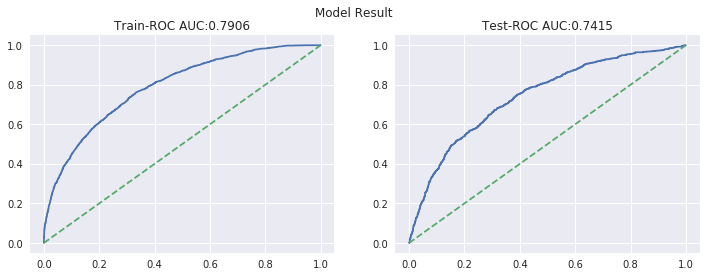

In [40]:
ym_result = model_test(ymx,ymy)

In [43]:
ym_result['fs_drop_feas']

['zx_ln_now_total_amt_level',
 'zx_cc_now_total_amt_level',
 'HOUSE_FUND_MONTH_PAYAMT']

### 2.1.2 友盟单模型特征重要度

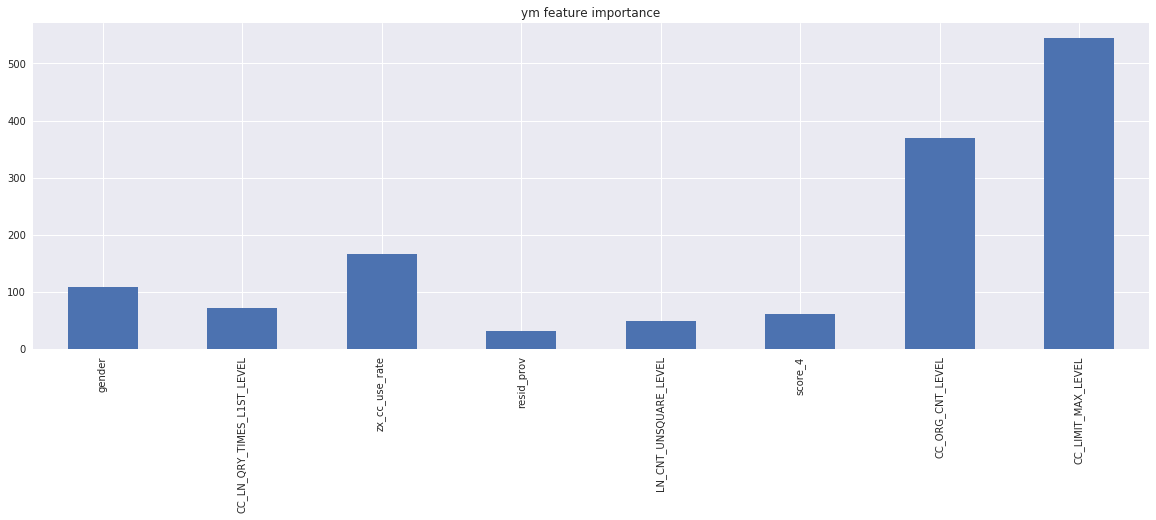

In [41]:
ym_importance = get_feature_importance(ym_result)
ym_importance.plot.bar(figsize=(20,6),title='ym feature importance', rot=90)

### 2.1.3 友盟单模型分渠道评估结果

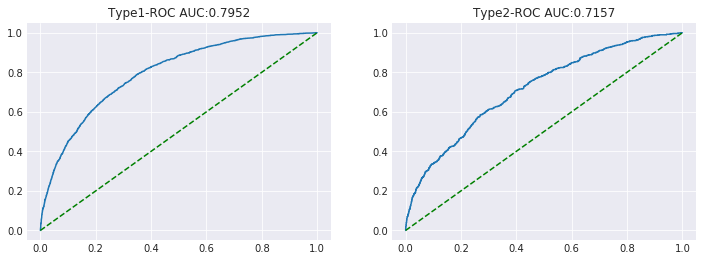

In [661]:
ym_model = ym_result['model']
fs_drop_feas = ym_result['fs_drop_feas']
single_eval(ymx,ymy,ym_comb,ym_model,fs_drop=fs_drop_feas,types=(1,2))

## 2.2 冰鉴-星宇分-单渠道建模

In [432]:
bjx = bj_comb.loc[:,~bj_comb.columns.str.contains('皓月|探查|_no|_NO|回溯|res_code|tag|md5|qd|命中|type')]
bjy = bj_comb['tag']

### 2.2.1 冰鉴单模型测试

4 features with a correlation magnitude greater than 0.99.

3 features with greater than 0.80 missing values.

16 features with a single unique value.

Total of 23 features identified for removal


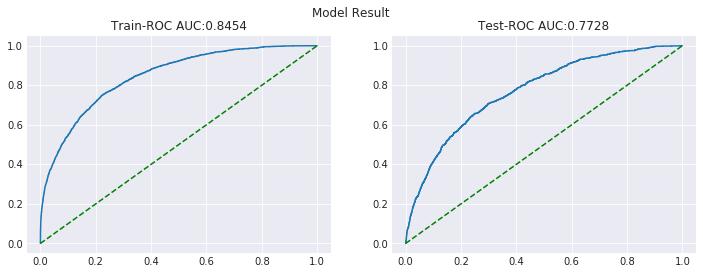

In [662]:
bj_result = model_test(bjx,bjy)

In [669]:
bj_result['fs_drop_feas']

['近1个月短期现金贷类产品信托资金类APP使用个数',
 '近6个月有APP使用的月份数_y',
 '近3个月线上代偿类产品银行资金类平台APP使用个数',
 '近3个月平均APP使用时间间隔_y',
 '近12个月线上代偿类产品信托资金类平台APP使用个数',
 '近6个月短期现金贷类产品信托资金类APP使用个数',
 '近1个月线上代偿类产品银行资金类平台APP使用个数',
 '近3个月短期现金贷类产品信托资金类APP使用个数',
 '近12个月线上短期现金贷类产品消金资金类平台APP使用个数',
 '近7日APP使用个数',
 '近12个月短期现金贷类产品信托资金类APP使用个数',
 '近3个月线上短期现金贷类产品消金资金类平台APP使用个数',
 '近6个月单日最大APP使用次数_y',
 '近3个月平均APP使用时间间隔_x',
 '近6个月线上短期现金贷类产品消金资金类平台APP使用个数',
 '近3个月线上代偿类产品信托资金类平台APP使用个数',
 '近1个月线上代偿类产品信托资金类平台APP使用个数',
 '近1个月APP使用次数_y',
 '近6个月线上代偿类产品信托资金类平台APP使用个数',
 '近12个月线上代偿类产品银行资金类平台APP使用个数',
 '近1个月线上短期现金贷类产品消金资金类平台APP使用个数',
 '近6个月线上代偿类产品银行资金类平台APP使用个数',
 '近1个月平均APP使用时间间隔']

### 2.2.2 冰鉴单模型特征重要度

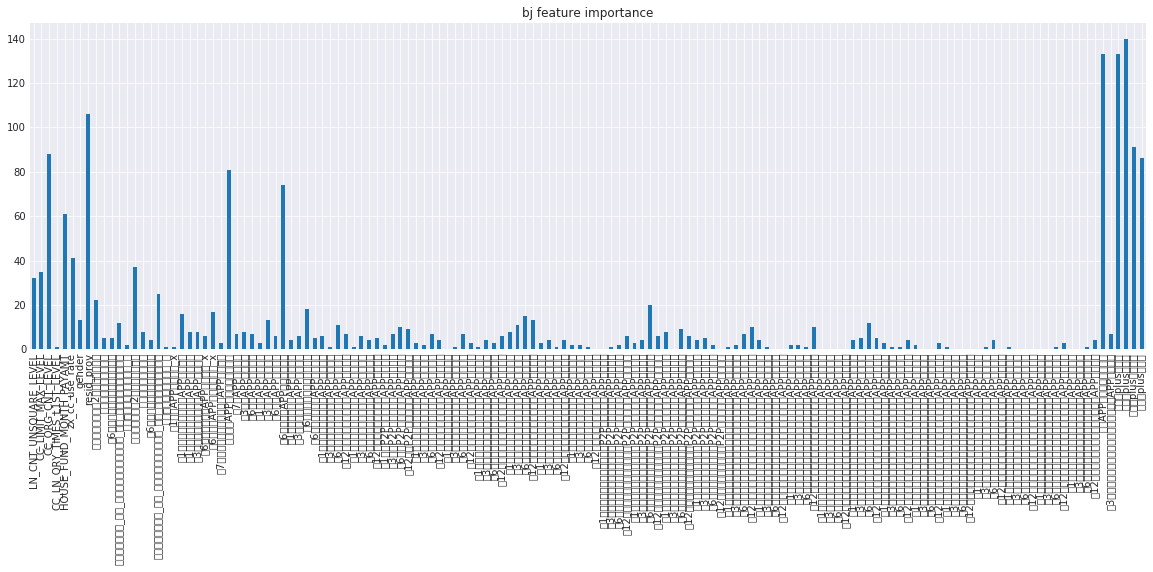

In [651]:
bj_importance = get_feature_importance(bj_result)
bj_importance.plot.bar(figsize=(20,6),title='bj feature importance', rot=90)

In [668]:
bj_importance

LN_CNT_UNSQUARE_LEVEL                    32
CC_LIMIT_MAX_LEVEL                       35
CC_ORG_CNT_LEVEL                         88
CC_LN_QRY_TIMES_L1ST_LEVEL                1
HOUSE_FUND_MONTH_PAYAMT                  61
zx_cc_use_rate                           41
gender                                   13
resid_prov                              106
按身份证号统计近2年查询的机构数                         22
历史关联身份证号个数                                5
近6个月对应的不同身份证号个数                           5
手机号的归属地_省市_与关联身份证号的归属地_省市_不一致的身份证号个数     12
关联身份证号归属地个数_省                             2
按手机号统计近2年查询的机构数                          37
历史关联手机号个数                                 8
近6个月对应的不同手机号个数                            4
身份证号的归属地_省市_与关联手机号的归属地_省市_不一致的手机号个数      25
关联手机号归属地个数_省                              1
近1个月APP使用次数_x                             1
近1个月线上大额类平台APP使用个数                       16
近1个月线上小额类平台APP使用个数                        8
近3个月线上小额类平台APP使用个数                        8
近6个月单日最大APP使用次数_x               

### 2.2.3 冰鉴单模型分渠道评估结果

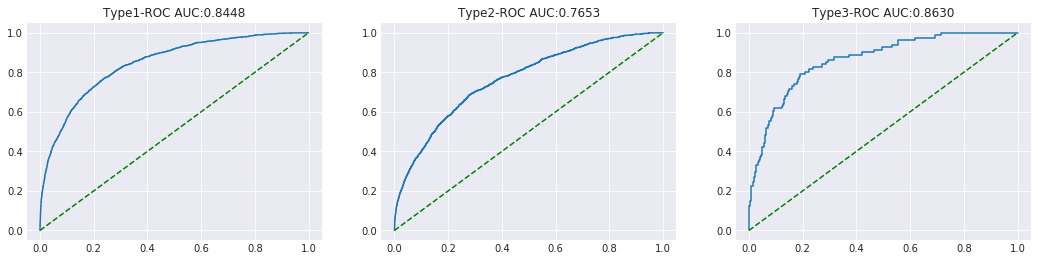

In [663]:
bj_model = bj_result['model']
fs_drop_feas = bj_result['fs_drop_feas']
single_eval(bjx,bjy,bj_comb,bj_model,fs_drop=fs_drop_feas,types=(1,2,3))

### 2.2.4 冰鉴10折交叉验证特征筛选¶

In [524]:
cross_val_sele_feas = kfold_selector(bjx,bjy,k=10)

1 fold
2 fold
3 fold
4 fold
5 fold
6 fold
7 fold
8 fold
9 fold
10 fold


In [528]:
len(cross_val_sele_feas['sele_features'])

73

In [527]:
ini.np.mean(cross_val_sele_feas['aucs'])

0.7669455222853998

## 2.3 全渠道建模

In [600]:
bjmr = bj_comb.loc[:,~bj_comb.columns.str.contains('皓月|探查|回溯|res_code|md5|qd|命中|type')]
all_comb = ym_comb.merge(bjmr,on='cert_no',how='outer')
del bjmr
all_comb['tag_x'] = all_comb['tag_x'].fillna(0)
all_comb['tag_y'] = all_comb['tag_y'].fillna(0)
all_comb['tag'] = all_comb['tag_y']+all_comb['tag_x']
all_comb['tag'] = all_comb['tag'].replace({2:1})

In [602]:
allx = all_comb.loc[:,~all_comb.coluSSmns.str.contains('_no|_NO|tag|md5|score_1|score_2|score_3|res_code|qd|type')]
ally = all_comb['tag']

13 features with a correlation magnitude greater than 0.99.

5 features with greater than 0.80 missing values.

16 features with a single unique value.

Total of 33 features identified for removal


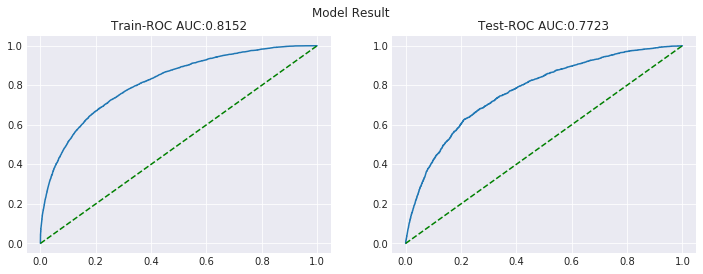

In [603]:
all_result = model_test(allx,ally)

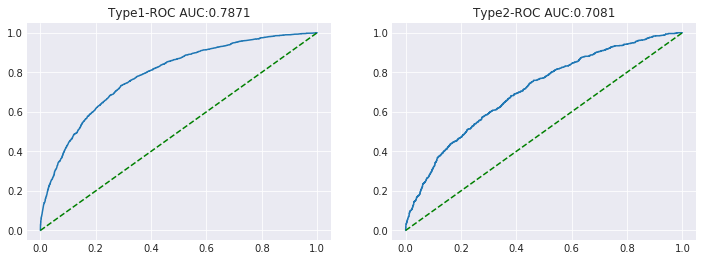

In [612]:
all_model = all_result['model']
fs_drop_feas = all_result['fs_drop_feas']
single_eval(allx,ally,comb=all_comb,mod=all_model,fs_drop=fs_drop_feas,types=[1,2])

In [670]:
all_comb['tag'].value_counts()

0.0    58113
1.0     6313
Name: tag, dtype: int64

In [8]:
import numpy as np
def my_med_loc(x):
    l = len(x)
    lx = sorted(x)
    if l%2 == 0:
        med = lx[int(l/2)]
    else:
        med = np.median(x)
    return med

In [9]:
my_med_loc([13,12,5,1,3,6,8,7])

7